In [1]:
# load module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import wntr
import wntr_utils
from sklearn.preprocessing import MinMaxScaler
from random import shuffle

In [3]:
# load STREaN data (STREaM is a simulator of end-uses and water demand patterns)
all_data_path = './data/allData.txt'

In [4]:
# Controls the pattern length
week_length = 7 
day_length = 24
number_of_weeks = 38 # roughly, 9 months

# We store the patterns into a .csv file
output_path = 'enhanced_ctown_38_weeks.csv'

# Create a water network model
inp_file = 'ctown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# We get all the junctions in the topology
node_list = list(wn.node_name_list)
junction_list  = []
for node in node_list:
    if wn.get_node(node).node_type == 'Junction':
        junction_list.append(str(node))
        
numbers_of_junctions = len(junction_list)        
df = pd.read_csv(all_data_path, header=None)

C:\Users\Azulm\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning: Not all curves were used in "ctown_map.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


In [6]:
# create headers
user_classes = ['low','average','high','morning','night']
headers = []
for user_class in user_classes:
    suffixes = (('_'+user_class+' ')*400).split() # original
    for suffix, number in zip(suffixes,range(1,401)):
        headers.append('user'+suffix+'_'+'%03d'%number)  
# reverse df and change df columns
df = df.T
df.columns = headers

Text(0.5, 1.0, '24 hours average, NIGHT users')

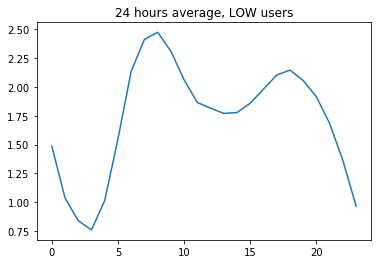

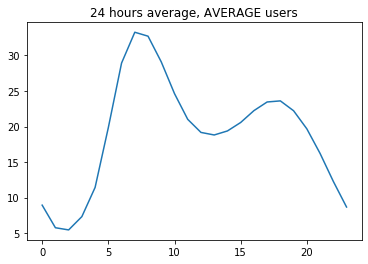

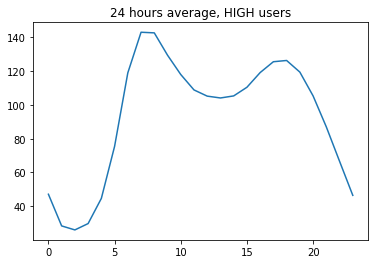

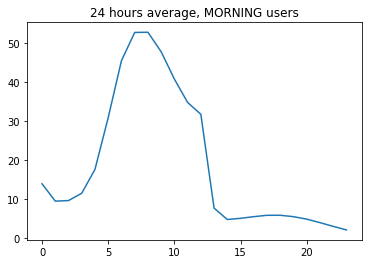

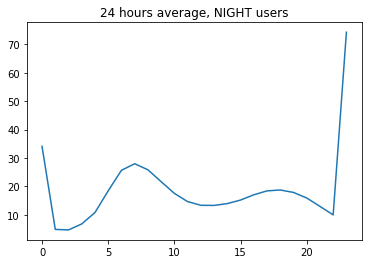

In [7]:
plt.figure()
plt.plot(df[headers[10:400]].mean(axis=1).values.reshape(-1,24).mean(axis=0))
plt.title('24 hours average, LOW users')

plt.figure()
plt.plot(df[headers[410:800]].mean(axis=1).values.reshape(-1,24).mean(axis=0))
plt.title('24 hours average, AVERAGE users')

plt.figure()
plt.plot(df[headers[810:1200]].mean(axis=1).values.reshape(-1,24).mean(axis=0))
plt.title('24 hours average, HIGH users')

plt.figure()
plt.plot(df[headers[1210:1600]].mean(axis=1).values.reshape(-1,24).mean(axis=0))
plt.title('24 hours average, MORNING users')

plt.figure()
plt.plot(df[headers[1610:2000]].mean(axis=1).values.reshape(-1,24).mean(axis=0))
plt.title('24 hours average, NIGHT users')


In [8]:
# remove first 10 of each class
users_to_remove = np.array(headers).reshape(-1,10)[::40].ravel().tolist()
df.drop(users_to_remove, axis = 1, inplace = True)
headers = df.columns

In [9]:
#length of patterns
n_hours = day_length*week_length*number_of_weeks
# total number of nodes and get nodes for each type of users
n_nodes = 400 # original
composition = np.array([20,50,20,5,5])
assert(composition.sum()==100)
nodes_per_users = (composition/100*n_nodes).astype(int)
nodes_per_users[1]=nodes_per_users[1]+n_nodes-nodes_per_users.sum()
assert(nodes_per_users.sum()==n_nodes)
n_dict = dict((user, n_nodes) for (user, n_nodes) in zip(user_classes, nodes_per_users))

In [10]:
n_hours

6384

In [11]:
# ['node_%003d'%i for i in range(1,n_nodes+1)]
df_patterns = pd.DataFrame(index=range(n_hours))
for user_class in user_classes:
    these_cols = [col for col in headers if user_class in col]
    these_nodes = n_dict[user_class]
    df_patterns = pd.concat([df_patterns,df[these_cols].sample(these_nodes, axis=1).iloc[:n_hours, :]], axis=1)

In [12]:
df_patterns

,user_low_114,user_low_154,user_low_161,user_low_225,user_low_092,user_low_363,user_low_038,user_low_123,user_low_078,user_low_160,...,user_night_235,user_night_119,user_night_106,user_night_214,user_night_373,user_night_262,user_night_351,user_night_396,user_night_387,user_night_228
0,6.0,5.0,0.0,6.0,0.0,8.0,0.0,0.0,0.0,0.0,...,7.0000,1.0,0.0,2.000,0.0,2.00000,1.000,0.0000,1.0,4.0
1,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,5.0,1.0,...,3.0000,9.0,0.0,5.000,1.0,0.00000,1.000,1.0000,0.0,9.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,10.1870,11.0,0.0,0.000,0.0,0.00000,0.000,0.0000,0.0,0.0
3,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,1.8132,0.0,0.0,3.000,0.0,10.44900,36.331,1.0000,0.0,5.0
4,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,...,6.0000,3.0,0.0,54.730,0.0,0.55058,71.669,0.0000,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6379,0.0,1.0,1.0,7.0,0.0,1.0,1.0,10.0,1.0,8.0,...,0.0000,4.0,7.0,45.978,22.0,8.00000,3.000,6.0000,9.0,6.0
6380,0.0,1.0,1.0,0.0,0.0,10.0,1.0,3.0,0.0,1.0,...,7.0000,8.0,27.0,46.022,5.0,2.00000,4.000,6.0000,13.0,7.0
6381,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0,...,0.0000,8.0,25.0,3.000,51.0,54.00000,9.000,3.0000,0.0,10.0
6382,0.0,0.0,0.0,1.0,3.0,8.0,13.0,0.0,0.0,0.0,...,0.0000,2.0,10.0,3.000,0.0,1.00000,24.000,2.0000,10.0,10.0


In [13]:
print(numbers_of_junctions)

388


In [15]:
cols =df_patterns.columns.to_list()
shuffle(cols)
df_patterns = df_patterns[cols]
dff = pd.DataFrame(index=df_patterns.index,columns=['pat1','pat2','pat3','pat4'])
dff['pat1']=df_patterns.iloc[:,:100].sum(axis=1)
dff['pat2']=df_patterns.iloc[:,100:200].sum(axis=1)
dff['pat3']=df_patterns.iloc[:,200:300].sum(axis=1)
dff['pat4']=df_patterns.iloc[:,300:400].sum(axis=1)

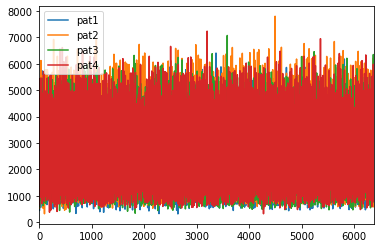

In [16]:
dff.plot()

In [14]:
# Write the resulting patterns
dff.to_csv(output_path)

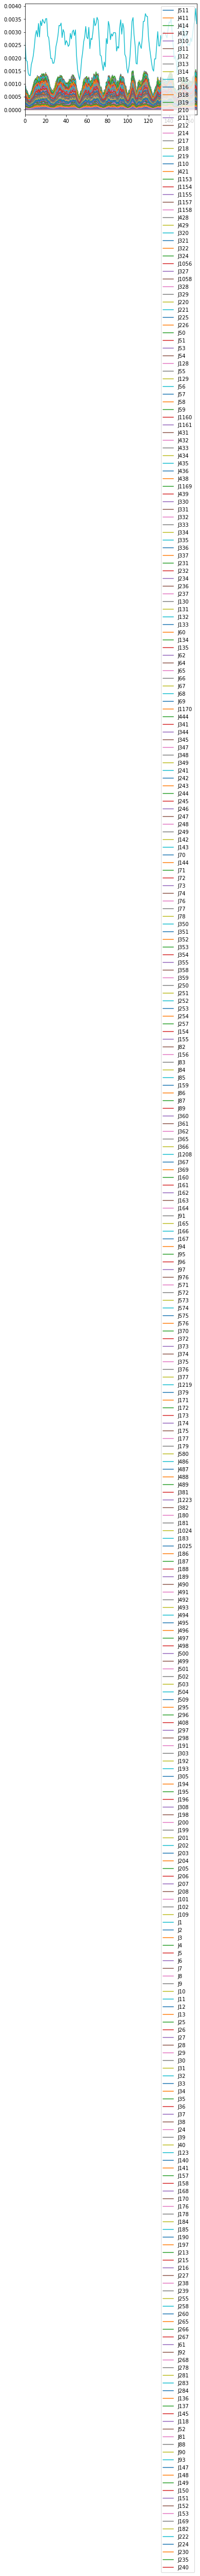

In [19]:
# Plot original pattern
df_old = wntr_utils.get_demand_patterns_from_nodes(wn)
df_old.plot()

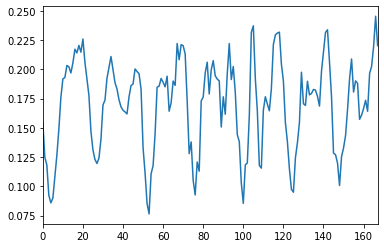

In [20]:
df_old.sum(axis=1).plot()


<<< New Demands (top 5) >>>
pat3    6.300058
pat2    6.159158
pat4    5.574353
pat1    5.558786
dtype: float64


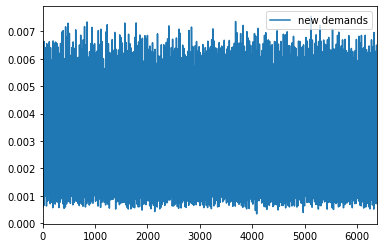

In [21]:
### load new demands
df_new = pd.read_csv(output_path, index_col=0)
d_max = 0.0025
constant = 0.00
scaler = MinMaxScaler(feature_range=(0, d_max))
temp = scaler.fit_transform(df_new.values.reshape(-1,1))
df_scaled = pd.DataFrame(columns = df_new.columns, data = temp.reshape(df_new.shape))+constant
print("\n<<< New Demands (top 5) >>>")
print(df_scaled.sum().sort_values(ascending=False).head())
df_scaled.sum(axis=1).plot(label = 'new demands')
plt.legend()

In [22]:
### substitute new demands
juncs = df_old.columns
juncs = juncs[(df_old.sum()>0).values] # these are the demand nodes
assert(len(juncs)==df_scaled.shape[1]) # check if they match columns in new demands
d_juncs = dict(zip(juncs,df_scaled.columns)) # match each demand node with new demand

# remove old patterns
for name in wn.junction_name_list:
    junc = wn.get_node(name)
    junc.demand_timeseries_list.pop()

for name in df_scaled.columns:
    wn.add_pattern(name=name, pattern=df_scaled[name].values)

for name in juncs:
    junc = wn.get_node(name)
    junc.add_demand(1,d_juncs[name])    

# check if demands coincide
df_check = wntr_utils.get_demand_patterns_from_nodes(wn)
plt.figure()
df_scaled.sum(axis=1).plot(label = 'loaded demands')
df_check.sum(axis=1).plot(label = 'retrieved demands', **{'linestyle':'dashed'})
plt.legend()

AssertionError: 

In [23]:
np.array([20,50,20,5,5])

array([20, 50, 20,  5,  5])